**CIFAR10 dataset (CNN-Pytorch)**

In [116]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [117]:
from torchvision import datasets
import torchvision.transforms as transformsInf
from torch.utils.data import SubsetRandomSampler

### **Load the train and test datasets and split the train datasets into train data and validation data (20%)**

In [118]:
batch_size = 20
validation_size = 0.2
num_workers = 0

transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_data = datasets.CIFAR10('data', download=True, train=True, transform=transform)
test_data = datasets.CIFAR10('data', download=True, train=False, transform=transform)

In [120]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(validation_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [123]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler = valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [176]:
img = iter(train_loader)
d,t = img.next()
d.shape

torch.Size([20, 3, 32, 32])

In [125]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

In [126]:
import torch.nn as nn
import torch.nn.functional as F

# **Define the Network Architecture**

In [127]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(64 * 4 * 4, 500)
    self.fc2 = nn.Linear(500, 10)

    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    x = x.view(-1, 64 * 4 * 4)

    x = self.dropout(x)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x


# **Verify the Network Architecture**

In [128]:
# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [129]:
import torch.optim as optim

# define a loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# **Training Model**

In [130]:
epochs = 20
train_losses , test_losses = [] , []
for e in range(epochs):
  running_loss = 0
  for images, labels in train_loader:
    images, labels = images.cuda(), labels.cuda()
    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits , labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  else:
    test_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():
      model.eval()
      for images , labels in valid_loader:
        images, labels = images.cuda(), labels.cuda()
        logits_test = model(images)
        test_loss += criterion(logits_test , labels)
        ps = torch.exp(logits_test)
        _, predicted = ps.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    model.train()
    train_losses.append(running_loss/len(train_loader))
    test_losses.append(test_loss/len(valid_loader))
    print("epochs {}/{}" .format(e+1 , epochs),
              "training loss: {:.3f}..".format(running_loss/len(train_loader)),
              "test loss: {:.3f}..".format(test_loss/len(valid_loader)),
              "test Accuracy: {:.3f}..".format(correct/total))

epochs 1/20 training loss: 2.220.. test loss: 1.915.. test Accuracy: 0.327..
epochs 2/20 training loss: 1.736.. test loss: 1.549.. test Accuracy: 0.430..
epochs 3/20 training loss: 1.515.. test loss: 1.395.. test Accuracy: 0.506..
epochs 4/20 training loss: 1.387.. test loss: 1.278.. test Accuracy: 0.546..
epochs 5/20 training loss: 1.288.. test loss: 1.200.. test Accuracy: 0.579..
epochs 6/20 training loss: 1.201.. test loss: 1.150.. test Accuracy: 0.591..
epochs 7/20 training loss: 1.132.. test loss: 1.068.. test Accuracy: 0.621..
epochs 8/20 training loss: 1.069.. test loss: 1.020.. test Accuracy: 0.643..
epochs 9/20 training loss: 1.012.. test loss: 0.957.. test Accuracy: 0.665..
epochs 10/20 training loss: 0.965.. test loss: 0.923.. test Accuracy: 0.676..
epochs 11/20 training loss: 0.921.. test loss: 0.889.. test Accuracy: 0.686..
epochs 12/20 training loss: 0.876.. test loss: 0.880.. test Accuracy: 0.691..
epochs 13/20 training loss: 0.836.. test loss: 0.822.. test Accuracy: 0.7

## ****Inference****

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------########-------------

Actual value is: dog 
Predicted value: dog

-------------########-------------


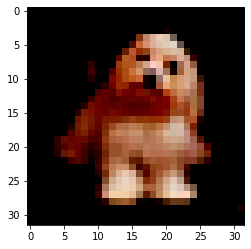

In [254]:
img = iter(train_loader)
images,labels = img.next()

preds = model(images[10].reshape(1,3,32,32).cuda())
_ , pred_img = torch.max(preds, 1)

act_val = classes[pred_img]
pred_val = classes[labels[10]]
print('-------------########-------------\n')
print("Actual value is: {} \nPredicted value: {}".format(act_val, pred_val))
print('\n-------------########-------------')
plt.imshow(images[10].permute(1,2,0))